In [1]:
# List of imports
import geopandas as gpd
import pandas as pd
import os
import pandana as pnd

import matplotlib.pyplot as plt

In [2]:
def get_nodes_and_edges(shp_file,rounding=5):
    """Use geopandas to read line shapefile and compile all paths and nodes in a line file based on a rounding tolerance.
    shp_file:path to polyline file with end to end connectivity
    rounding: tolerance parameter for coordinate precision"""
    edges = gpd.read_file(shp_file)
    edges["from_x"]=edges["geometry"].apply(lambda x:round(x.coords[0][0],rounding))
    edges["from_y"]=edges["geometry"].apply(lambda x:round(x.coords[0][1],rounding))
    edges["to_x"]=edges["geometry"].apply(lambda x:round(x.coords[-1][0],rounding))
    edges["to_y"]=edges["geometry"].apply(lambda x:round(x.coords[-1][1],rounding))
    nodes_from = edges[["from_x","from_y"]].rename(index=str,columns={"from_x":"x","from_y":"y"})
    nodes_to = edges[["to_x","to_y"]].rename(index=str,columns={"to_x":"x","to_y":"y"})
    nodes = pd.concat([nodes_from,nodes_to],axis=0)
    nodes["xy"] = list(zip(nodes["x"], nodes["y"]))
    nodes = pd.DataFrame(nodes["xy"].unique(),columns=["xy"])
    nodes["x"] = nodes["xy"].apply(lambda x: x[0])
    nodes["y"] = nodes["xy"].apply(lambda x: x[1])
    nodes = nodes[["x","y"]].copy()
    return nodes , edges

def generate_pandana_store_from_shp(hdf5_path,shp_file,weights=["weight"],oneway=None,overwrite_existing=True,rounding=6):
    """Generate a pandana ready HDF5 store using geopandas (gdal required) and pandas. Python 3.5. 
    hdf5_path(str): output path of HDF5 store holding two dataframes ["nodes","edges"]
    shp_file(str): input file that geopandas reads to make a graph based on end to end connectivity
    weights(list): weights columns transfered to the store edges. Name is maintained. 
    oneway(str): series where oneway streets (edges) are denoted with a 1, 0 denotes twoway. None, assumes
    twoway edge. 
    overwrite_existing(bool): if true, the existing store is overwritten.
    rounding(int): the number of digits to round line coordinates to get unique nodes (precision)
    returns hdf5_path(str)"""
    if os.path.exists(hdf5_path):
        if overwrite_existing:
            print("Overwriting existing store...")
            os.remove(hdf5_path)
        else:
            print("Existing store at path: {0}".format(hdf5_path))
            return hdf5_path
    all_edges_twoway = True
    oneway_field_list = []
    if oneway is not None:
        all_edges_twoway = False
        oneway_field_list.append(oneway)
    print("Reading shapefile with geopandas: {0}...".format(shp_file))
    nodes, edges =get_nodes_and_edges(shp_file,rounding)
    h5store = pd.HDFStore(hdf5_path)
    print("Establishing node store...")
    df_nodes = nodes
    h5store['nodes'] = df_nodes
    df_nodes['nodeid'] = df_nodes.index.values
    edge_cnt = len(edges)
    print("Establishing edge store for {0} edges...".format(edge_cnt))
    df_edges= edges[['from_x','from_y','to_x','to_y'] + weights + oneway_field_list].copy()
    print("Transferring nodeids to edges...")
    df_edges=pd.merge(df_edges, df_nodes, how='left', left_on=['from_x','from_y'], right_on=['x','y'])
    df_edges=pd.merge(df_edges, df_nodes, how='left', left_on=['to_x','to_y'], right_on=['x','y'], suffixes=('_from', '_to'))
    #nodeids are duplicated on from the joined nodes, joined first to from, suffix to on next set
    df_edges.rename(columns= {'nodeid_from': 'from', 'nodeid_to': 'to'}, inplace=True)
    df_edges=df_edges[['from','to'] + weights + oneway_field_list]
    if all_edges_twoway:
        pass
    else:
        print("Setting up twoway edges...")
        twoway_edges = df_edges[df_edges[oneway]==0].copy()
        twoway_to = twoway_edges["to"].copy()
        twoway_edges["to"] = twoway_edges["from"]
        twoway_edges["from"] = twoway_to
        df_edges = pd.concat([df_edges,twoway_edges])
    h5store['edges']=df_edges
    h5store.close()
    print("Graph store construction complete...")
    return hdf5_path

In [3]:
# Load Shp to import
nodes, edges = get_nodes_and_edges('./portugal/gis_osm_roads_free_1.shp')

In [4]:
nodes.head()

,x,y
0,-9.39792,38.95443
1,-9.39593,38.95662
2,-9.41948,38.97215
3,-9.39941,38.95519
4,-9.39858,38.95692


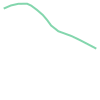

In [24]:
edges.head()
edges.geometry[0]

In [22]:
edges.geometry[3]

AttributeError: 'LineString' object has no attribute 'plot'

In [13]:
path = generate_pandana_store_from_shp('./data/portugal', './portugal/gis_osm_roads_free_1.shp')

Overwriting existing store...
Reading shapefile with geopandas: ./portugal/gis_osm_roads_free_1.shp...
Establishing node store...
Establishing edge store for 898014 edges...


KeyError: "['weight'] not in index"